In [1]:
import pandas as pd
from collections import defaultdict
import numpy as np
from rdkit.Chem import MolFromSmiles, MolToSmiles
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
mix_df = pd.read_csv("../mixture_smi_definitions_clean.csv")
gslf_df = pd.read_csv("../..//gs-lf/gs-lf_combined.csv")
snitz_3_df = pd.read_csv("snitz3_jaccard.csv")

In [7]:
def transform_dataframe(df):
    # Create a dictionary to store unique SMILES and their sources
    smiles_dict = defaultdict(list)
    
    # Iterate through the DataFrame
    for _, row in df.iterrows():
        dataset = row['Dataset']
        mixture_label = row['Mixture Label']
        source = f"{dataset}_{mixture_label}"
        
        # Check all smi_n columns
        for col in df.columns:
            if col.startswith('smi_'):
                smiles = row[col]
                if pd.notna(smiles):  # Check if the SMILES is not NaN
                    smiles_dict[smiles].append(source)
    
    # Create the new DataFrame
    new_df = pd.DataFrame({
        'SMILES': list(smiles_dict.keys()),
        'Sources': [','.join(sources) for sources in smiles_dict.values()]
    })
    
    return new_df

In [8]:
mix_df = mix_df[mix_df['Dataset'] == 'Snitz 3'].copy()

In [9]:
mix_df

,Dataset,Mixture Label,smi_0,smi_1,smi_2,smi_3,smi_4,smi_5,smi_6,smi_7,...,smi_33,smi_34,smi_35,smi_36,smi_37,smi_38,smi_39,smi_40,smi_41,smi_42
703,Snitz 3,1,CC(=O)c1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
704,Snitz 3,2,CCCCCC1CCC(=O)O1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
705,Snitz 3,3,CC(=O)OCCC(C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
706,Snitz 3,4,COc1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
707,Snitz 3,5,O=Cc1ccccc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
708,Snitz 3,6,CC(=O)O[C@@H]1C[C@@H]2CC[C@@]1(C)C2(C)C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
709,Snitz 3,7,CCCCSCCCC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
710,Snitz 3,8,Cc1ccc(OC(=O)C(C)C)cc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
711,Snitz 3,9,COc1ccc(C)cc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712,Snitz 3,10,CC(C)c1ccc(C=O)cc1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
mix_smi_df = transform_dataframe(mix_df)
mix_smi_df['canonical_smiles'] = mix_smi_df.apply(lambda row: MolToSmiles(MolFromSmiles(row['SMILES'])), axis=1)
gslf_df['canonical_smiles'] = gslf_df.apply(lambda row: MolToSmiles(MolFromSmiles(row['IsomericSMILES'])), axis=1)

merged_df = pd.merge(mix_smi_df, gslf_df, on='canonical_smiles', how='left')

In [51]:
def calculate_jaccard_distances(df, start_col=6):
    # Select columns from start_col to the end
    selected_columns = df.iloc[:, start_col:]
    
    # Identify rows with NaN values
    rows_with_nan = selected_columns.isna().any(axis=1)
    
    # Convert to binary (presence/absence) matrix, treating NaN as absence
    binary_matrix = (selected_columns.notna() & (selected_columns != 0)).astype(int)
    
    # Calculate pairwise Jaccard distances
    jaccard_distances = pdist(binary_matrix, metric='sokalmichener')
    
    # Convert distance vector to a square matrix
    jaccard_matrix = squareform(jaccard_distances)
    
    # Create a mask for rows and columns with NaN
    nan_mask = rows_with_nan.values[:, np.newaxis] | rows_with_nan.values
    
    # Apply the mask to the jaccard_matrix
    jaccard_matrix[nan_mask] = np.nan
    
    # Create a DataFrame with row and column labels
    jaccard_df = pd.DataFrame(jaccard_matrix, index=df.index, columns=df.index)
    
    return jaccard_df, jaccard_matrix.flatten()

In [52]:
jaccard_df, jaccard_distances = calculate_jaccard_distances(merged_df)

In [53]:
snitz_3_df['GSLF Hamming'] = snitz_3_df.apply(lambda row: jaccard_df[row['Mixture 1 ID']-1][row['Mixture 2 ID']-1], axis=1)

In [54]:
snitz_3_df

,Dataset,Mixture 1,Mixture 2,Experimental Values,Mixture 1 ID,Mixture 2 ID,GSLF Jaccard,GSLF Cosine,GSLF Hamming
0,Snitz 3,CC(=O)C1=CC=CC=C1,CSSSC,0.853163,1,45,1.000000,1.000000,0.243590
1,Snitz 3,CCCCCC1CCC(=O)O1,CCC(=O)OCC,0.695015,2,17,0.937500,0.882149,0.197368
2,Snitz 3,CC(C)CCOC(=O)C,COC1=C(C=CC(=C1)CC=C)O,0.579065,3,19,0.933333,0.870901,0.185430
3,Snitz 3,COC1=CC=CC=C1,CCCCCCCO,0.517855,4,24,0.941176,0.866369,0.209150
4,Snitz 3,C1=CC=C(C=C1)C=O,CCCCCCO,0.403795,5,30,0.800000,0.666667,0.161074
...,...,...,...,...,...,...,...,...,...
69,Snitz 3,CCCCCCCCCOC(=O)C,CC1=CC2=C(C=C1)N=CC=C2,0.496486,44,21,0.833333,0.711325,0.136054
70,Snitz 3,CCCCCCCCCOC(=O)C,C=CCCC(=O)O,0.723162,44,26,1.000000,1.000000,0.161074
71,Snitz 3,CCCCC(=O)O,CC1=CC=CC=C1C=O,0.808075,36,40,1.000000,1.000000,0.148649
72,Snitz 3,C=CCCC(=O)O,C1=CC=C(C=C1)CCO,0.739664,26,15,1.000000,1.000000,0.136054


Text(0.5, 1.0, 'Augmented GSLF Jaccard vs Single Molecular Similarity')

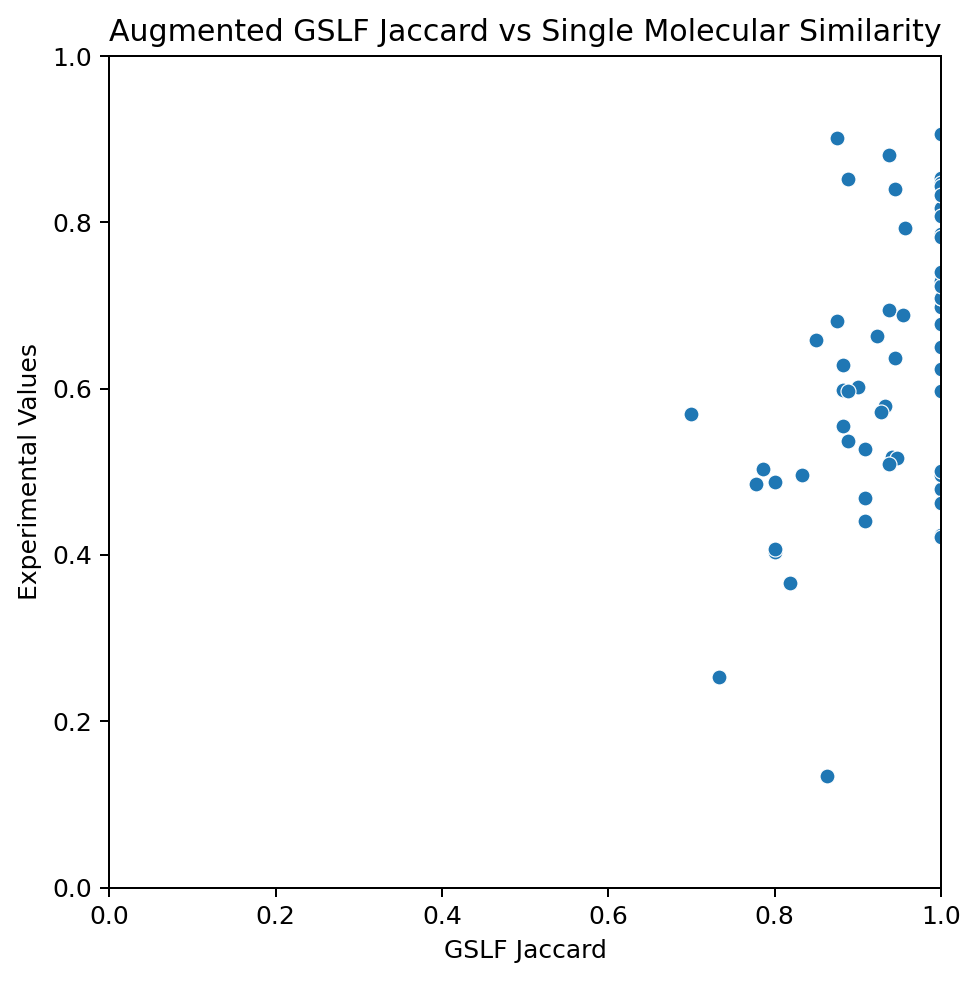

In [55]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
g = sns.scatterplot(x='GSLF Jaccard', y='Experimental Values', data=snitz_3_df, ax=ax)
ax.set_aspect('equal')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_title('Augmented GSLF Jaccard vs Single Molecular Similarity')

(0.5, 1.0)

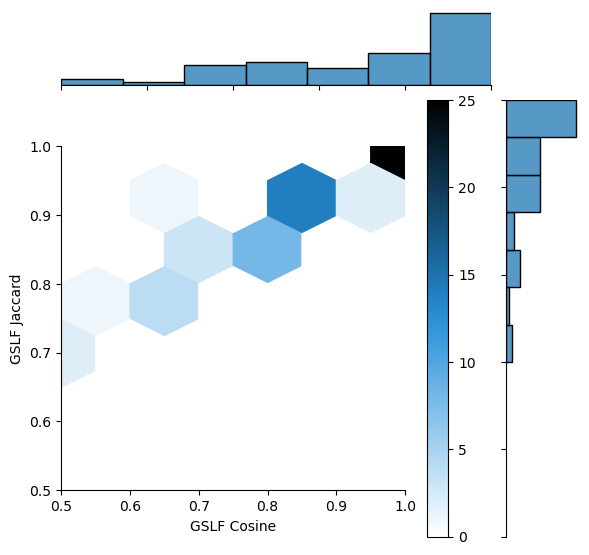

In [70]:
#fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)

g = sns.jointplot(x='GSLF Cosine', y='GSLF Jaccard', kind='hex', data=snitz_3_df)
# Add color bar for the hex plot
plt.colorbar(g.ax_joint.collections[0], ax=g.ax_joint)
# Make aspect ratio equal for joint plot
g.ax_joint.set_aspect('equal')

g.ax_joint.set_xlim([0.5,1])
g.ax_joint.set_ylim([0.5,1])


Text(0.5, 1.0, 'Augmented GSLF Cosine vs Single Molecular Similarity')

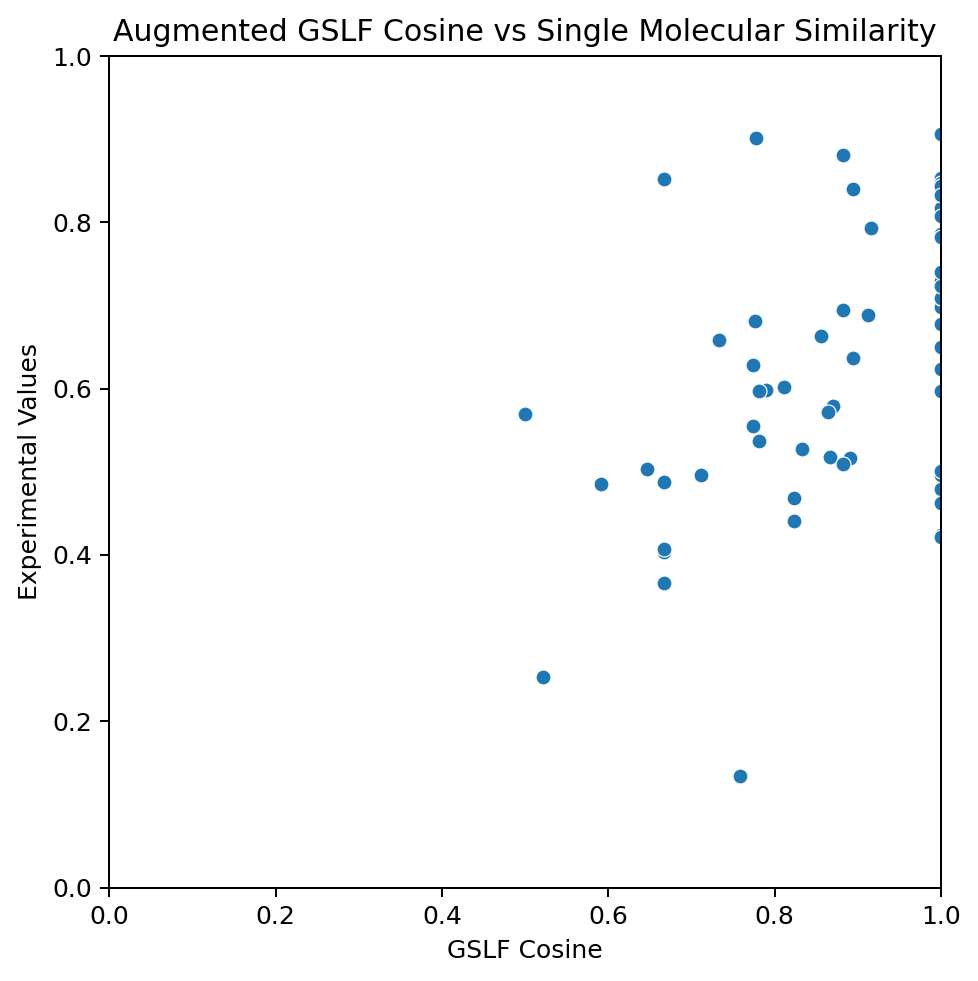

In [56]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
g = sns.scatterplot(x='GSLF Cosine', y='Experimental Values', data=snitz_3_df, ax=ax)
ax.set_aspect('equal')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_title('Augmented GSLF Cosine vs Single Molecular Similarity')

Text(0.5, 1.0, 'Augmented GSLF Hamming vs Single Molecular Similarity')

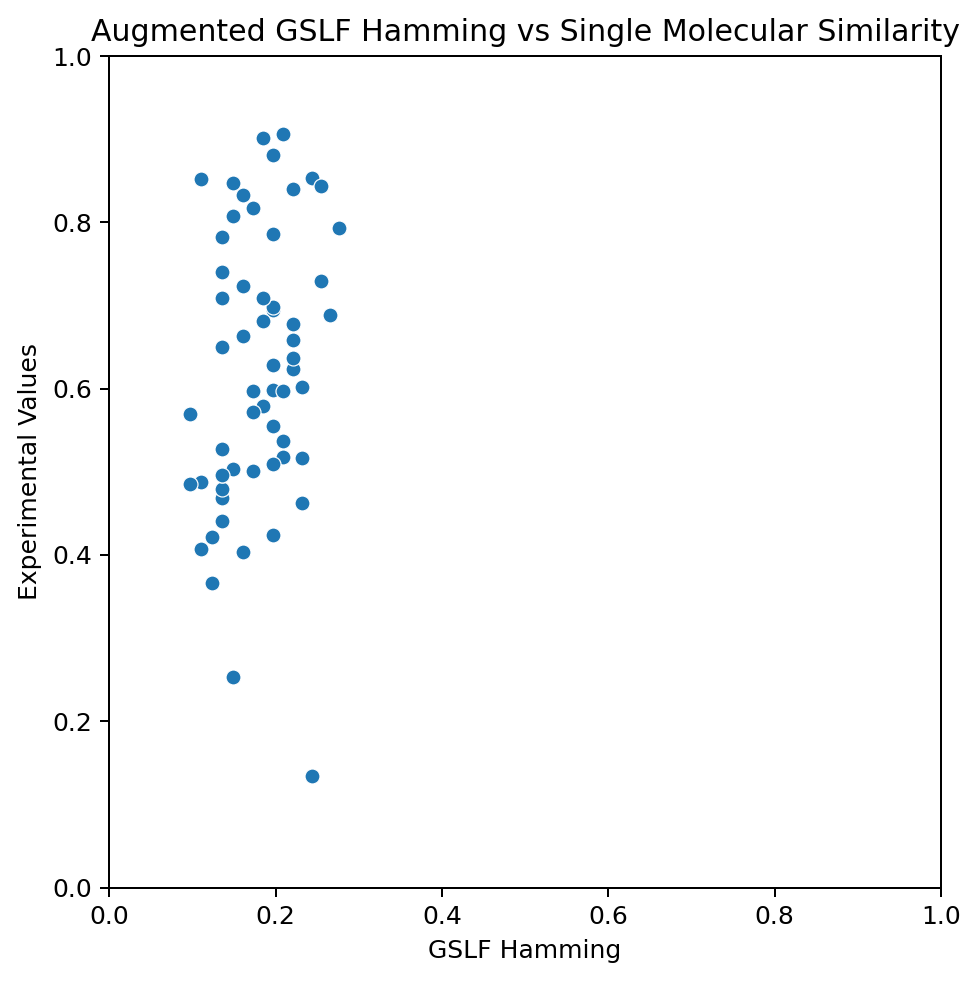

In [57]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
g = sns.scatterplot(x='GSLF Hamming', y='Experimental Values', data=snitz_3_df, ax=ax)
ax.set_aspect('equal')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_title('Augmented GSLF Hamming vs Single Molecular Similarity')

In [58]:
from scipy.stats import pearsonr

In [59]:
df = snitz_3_df.dropna().reset_index()

In [60]:
pearsonr(df['GSLF Hamming'], df['Experimental Values'])[0]

0.23810810640325103

In [32]:
dg = df[df['GSLF Cosine'] < 1.0]

In [33]:
pearsonr(dg['GSLF Cosine'], dg['Experimental Values'])[0]

0.42673143886975423

In [122]:
df

,index,Dataset,Mixture 1,Mixture 2,Experimental Values,Mixture 1 ID,Mixture 2 ID,GSLF Jaccard
0,0,Snitz 3,CC(=O)C1=CC=CC=C1,CSSSC,0.853163,1,45,1.000000
1,1,Snitz 3,CCCCCC1CCC(=O)O1,CCC(=O)OCC,0.695015,2,17,0.937500
2,2,Snitz 3,CC(C)CCOC(=O)C,COC1=C(C=CC(=C1)CC=C)O,0.579065,3,19,0.933333
3,3,Snitz 3,COC1=CC=CC=C1,CCCCCCCO,0.517855,4,24,0.941176
4,4,Snitz 3,C1=CC=C(C=C1)C=O,CCCCCCO,0.403795,5,30,0.800000
5,6,Snitz 3,CCCCSCCCC,CC(C1=CC=CC=C1)C(OC)OC,0.658640,7,20,0.850000
6,7,Snitz 3,CC1=CC=C(C=C1)OC(=O)C(C)C,COC(=O)C1=CC=CC=C1N,0.487870,8,46,0.800000
7,8,Snitz 3,CC1=CC=C(C=C1)OC,CCCC(=O)SC,0.881245,9,33,0.937500
8,9,Snitz 3,CC(C)C1=CC=C(C=C1)C=O,CCCCCCCCCOC(=O)C,0.468505,10,44,0.909091
9,11,Snitz 3,CCSCC,C=CCCC(=O)O,0.479247,12,26,1.000000
